In [22]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline

## Logic Based FizzBuzz Function [Software 1.0]

In [23]:
def fizzbuzz(n):
    
    # FizzBuzz problem states that any number that if there is any number that is divisible by 3, it will be returning 
    #'Fizz', if the number is divisible by 5, if it will be returning 'Buzz' and if it is divisible by both the numbers 
    # i.e 3 and 5, that number will be returning 'FizzBuzz'.If the input number is not divisible by either 
    # 3 or 5, it will return 'Other'.
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [24]:
def createInputCSV(start,end,filename):
    
    # We are using List because of its dynamic behaviour. The first list will store all the input digits and the output 
    # list will contain the Fizz Buzz and FizzBuzz with respect to the input List.
    inputData   = []
    outputData  = []
    
    # We require training data because it acts as dataset that is used to train the model to behave it automatically in
    #the expected way.
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Dataframes is the data structure provided by the panda in order to make the data manipulation simpler.Dataframes
    #has tabular structure containing rows and columns that can be selected or replaced by reshaping the dataset according
    # to the requirement.
    #In the code below we are creating the Dataframes and assigning the provided input and label to it.
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Here we are trying to write our Dataframe to a csv file. We are writting it in .csv file because we want our data to 
    #be saved in the tabular format and .csv file is acceptable by most of the spreadsheet applications.
    # Print "Created" if data id successfully deployed in the .csv file.
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [150]:
def processData(dataset):
    
    # Data is basically storing all the numbers and labels is storing the output and then 
    # for the input to be in the same tensorflow matrix format we are processing the inputs.
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [26]:
import numpy as np

def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        # Because we have to process the training data ranging from 101 to 1000 so for processing
        # 1000 examples in the training set, we need to have 10 bits. Therefore, we have taken d in range of 10.
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [27]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

In [28]:
# Below code is used to create .csv files and to write training and testing data into them.
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [29]:
# Read Dataset
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

## Tensorflow Model Definition

In [30]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 10])
outputTensor = tf.placeholder(tf.float32, [None, 4])

In [264]:
NUM_HIDDEN_NEURONS_LAYER_1 = 2000
LEARNING_RATE = 0.02

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

# Training the Model

In [273]:
NUM_OF_EPOCHS = 7500
BATCH_SIZE = 50

training_accuracy = []

with tf.Session() as sess:
    
    # Set Global Variables ?
    tf.global_variables_initializer().run()

    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
        
    writer = tf.summary.FileWriter('.', sess.graph)
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

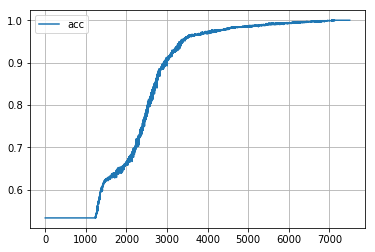

In [270]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [271]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

In [272]:
wrong   = 0
right   = 0

predictedTestLabelList = []
""
for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "ektakati")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50291702")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabelList

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 0  Correct :100
Testing Accuracy: 100.0
